In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, BatchNormalization, InputLayer
from keras.utils import to_categorical
from keras.layers import Flatten

from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


2025-04-26 04:37:15.478415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745642235.655116      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745642235.705859      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')
df.drop(['Unnamed'], axis=1, errors='ignore', inplace=True)

# Convert labels to categorical: class 1 = seizure, 2–5 = non-seizure
df['y'] = df['y'].apply(lambda x: 1 if x == 1 else 0)

# Split features and labels
X = df.drop('y', axis=1).values
y = df['y'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for Conv1D and LSTM: (samples, timesteps, features)
X_cnn = X.reshape((X.shape[0], X.shape[1], 1))

# One-hot encode labels for deep learning
y_cat = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cat, test_size=0.2, random_state=42)


In [4]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


9200
2300
9200
2300


In [5]:
# Load dataset
df = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')

# Drop non-feature columns
# X = df.drop(columns=['Unnamed: 0', 'y'])

# Keep only numeric columns (this is the fix!)
df_numeric = df.select_dtypes(include='number')

# Step 1: Row-wise mean and stda
feature_mean = df_numeric.mean(axis=1)
feature_std = df_numeric.std(axis=1)

# Step 2: Combine into new DataFrame
stats_df = pd.DataFrame({
    'Feature_Mean': feature_mean,
    'Feature_STD': feature_std
})

# Step 3: Now describe this stats_df
final_stats = stats_df.describe()

# Show result
print(final_stats)


       Feature_Mean   Feature_STD
count  11500.000000  11500.000000
mean      -7.662534    101.695489
std       32.531657    125.240179
min     -231.368715     10.733474
25%      -25.268156     36.505445
50%       -6.220670     50.996048
75%       10.107542     90.075583
max      244.815642    808.122407


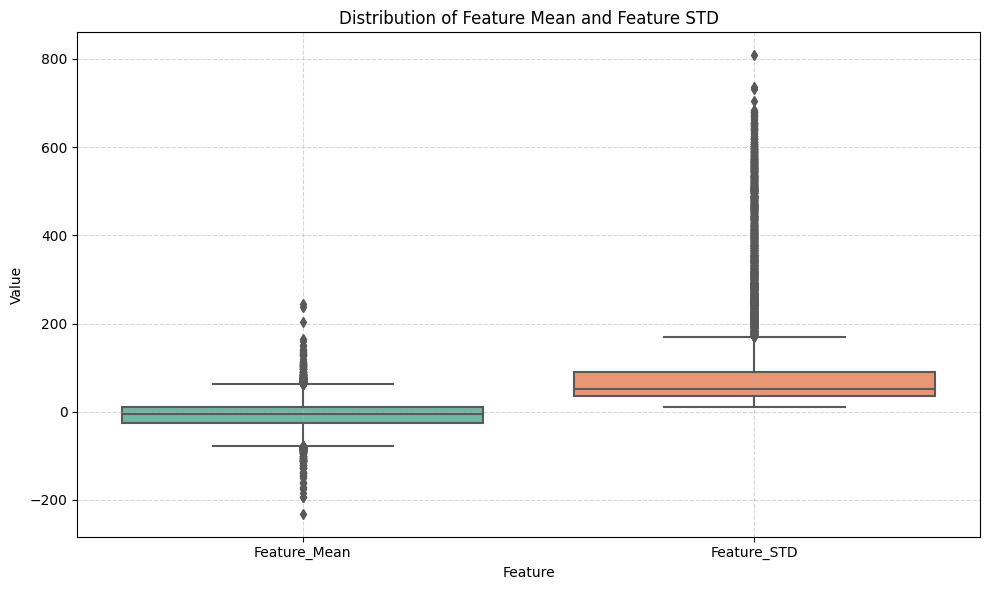

In [6]:

# Load dataset
df = pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')

# Keep only numeric columns
df_numeric = df.select_dtypes(include='number')

# Step 1: Row-wise mean and std
feature_mean = df_numeric.mean(axis=1)
feature_std = df_numeric.std(axis=1)

# Step 2: Combine into a new DataFrame
stats_df = pd.DataFrame({
    'Feature_Mean': feature_mean,
    'Feature_STD': feature_std
})

# Melt the dataframe for seaborn boxplot
df_melted = pd.melt(stats_df, value_vars=['Feature_Mean', 'Feature_STD'])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='variable', y='value', palette='Set2')
plt.title('Distribution of Feature Mean and Feature STD')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
model_cnn_bilstm = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_cnn_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model_cnn_bilstm.fit(X_train, y_train, epochs=20, batch_size=64, 
                                validation_data=(X_test, y_test),
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
                                verbose=1)


I0000 00:00:1745639201.517051    1536 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1745639206.707001    1588 cuda_dnn.cc:529] Loaded cuDNN version 90300


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9102 - loss: 0.2588 - val_accuracy: 0.9600 - val_loss: 0.1281
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9560 - loss: 0.1102 - val_accuracy: 0.9635 - val_loss: 0.0757
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9623 - loss: 0.0908 - val_accuracy: 0.9726 - val_loss: 0.0689
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9647 - loss: 0.0840 - val_accuracy: 0.9717 - val_loss: 0.0839
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9716 - loss: 0.0750 - val_accuracy: 0.9809 - val_loss: 0.0618
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9763 - loss: 0.0665 - val_accuracy: 0.9735 - val_loss: 0.0643
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9778 - loss: 0.0638 - val_accuracy: 0.9822 - val_loss: 0.0516
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9812 - loss: 0.0535 - val_accuracy: 0.980

In [8]:
model_cnn_bilstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 176, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 86, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,488 (1.51 MB)

 Trainable params: 132,162 (516.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 264,326 (1.01 MB)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1835
           1       0.99      0.97      0.98       465

    accuracy                           0.99      2300
   macro avg       0.99      0.98      0.99      2300
weighted avg       0.99      0.99      0.99      2300



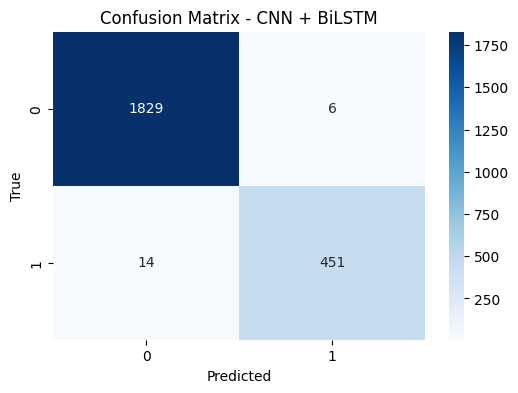

In [9]:
# Predictions and accuracy
y_pred_dl = model_cnn_bilstm.predict(X_test)
y_pred_dl_cls = np.argmax(y_pred_dl, axis=1)
y_test_cls = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_dl_cls)
print("Classification Report:\n", classification_report(y_test_cls, y_pred_dl_cls))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN + BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


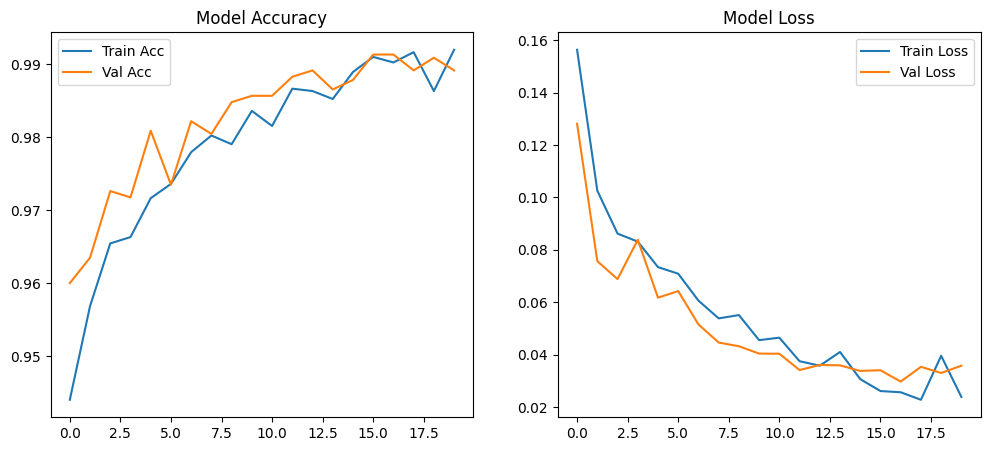

In [10]:
# Accuracy & Loss Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


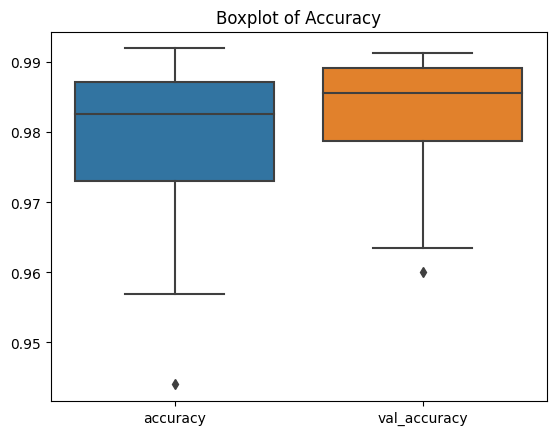

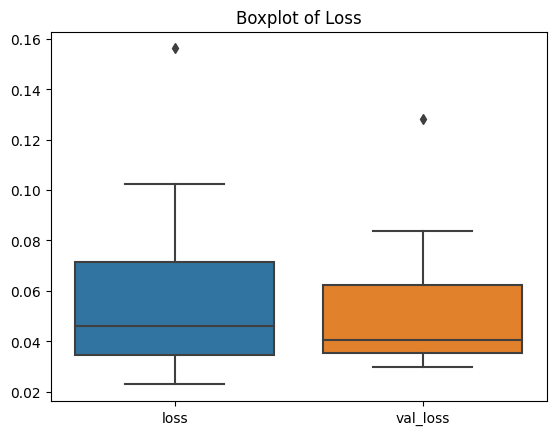

In [11]:
# Box plots of accuracy & loss
history_df = pd.DataFrame(history.history)

sns.boxplot(data=history_df[['accuracy', 'val_accuracy']])
plt.title("Boxplot of Accuracy")
plt.show()

sns.boxplot(data=history_df[['loss', 'val_loss']])
plt.title("Boxplot of Loss")
plt.show()


In [12]:
# CNN-only model
cnn_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)[1]

# LSTM-only model
lstm_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)[1]

# SVM model
X_flat = X.reshape(X.shape[0], -1)
X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_flat, y, test_size=0.2, random_state=42)
svm = SVC(kernel='rbf')
svm.fit(X_train_flat, y_train_flat)
svm_acc = accuracy_score(y_test_flat, svm.predict(X_test_flat))

# CNN+BiLSTM accuracy already computed
cnn_bilstm_acc = accuracy_score(y_test_cls, y_pred_dl_cls)

# Print all accuracies
print(f"CNN Accuracy:         {cnn_acc:.4f}")
print(f"LSTM Accuracy:        {lstm_acc:.4f}")
print(f"SVM Accuracy:         {svm_acc:.4f}")
print(f"CNN+BiLSTM Accuracy:  {cnn_bilstm_acc:.4f}")


I0000 00:00:1745639278.788712    1586 service.cc:148] XLA service 0x7e84906c1c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745639278.788746    1586 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745639280.710297    1586 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CNN Accuracy:         0.9813
LSTM Accuracy:        0.9500
SVM Accuracy:         0.9783
CNN+BiLSTM Accuracy:  0.9913


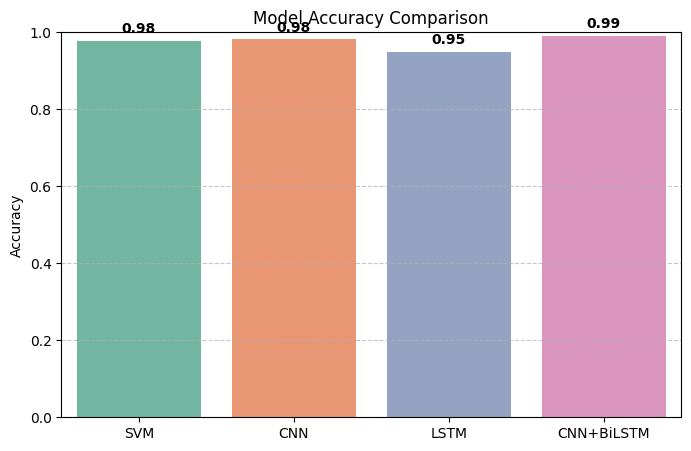

In [13]:
# 📊 Accuracy Barplot
model_names = ['SVM', 'CNN', 'LSTM', 'CNN+BiLSTM']
accuracies = [svm_acc, cnn_acc, lstm_acc, cnn_bilstm_acc]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='Set2')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=10, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
